In [ ]:
import pandas as pd
import numpy as np
import requests

#pip install gradio_client

In [4]:
#import csv filee interactions_train.csv
interactions = pd.read_csv('kaggle_data/interactions_train.csv')
items = pd.read_csv('kaggle_data/items.csv')

display(interactions.head())
display(items.head())

#limited to 100 rows
limited_items = items.head(100)

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


# Understand the data

In [23]:
#count the number of elements in each column
count_elements = items.count()
count_elements

Title         15291
Author        12638
ISBN Valid    14568
Publisher     15266
Subjects      13068
i             15291
dtype: int64

In [22]:
# How many books did people read?
books_per_user = interactions.groupby('u')['i'].count()

summary_stats = books_per_user.describe()
print(summary_stats)

count    7838.000000
mean       11.105767
std        16.441875
min         3.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       385.000000
Name: i, dtype: float64


In [ ]:
#missing values for items
missing_values = items.isnull().sum()
missing_values

Title            0
Author        2653
ISBN Valid     723
Publisher       25
Subjects      2223
i                0
dtype: int64

# 1. Collaborative Filtering
    Recommendations based on user-item interactions. 


In [28]:
# Create a user-item interaction matrix with binary values (1 if read, 0 otherwise)
binary_interaction_matrix = interactions.pivot_table(index='u', columns='i', values='t', aggfunc='count')
binary_interaction_matrix = binary_interaction_matrix.notnull().astype(int)

binary_interaction_matrix

i,0,1,2,3,4,5,6,7,8,9,...,15280,15281,15282,15283,15284,15285,15287,15288,15289,15290
u,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


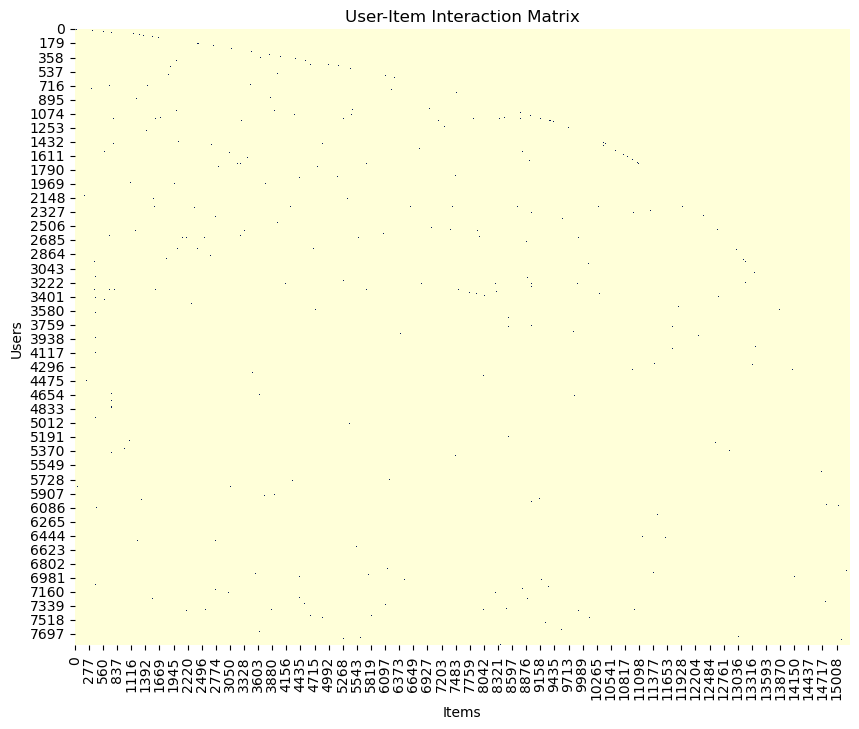

In [29]:
#display the matrix with colors as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(binary_interaction_matrix, cmap='YlGnBu', cbar=False)
plt.title('User-Item Interaction Matrix')
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()

In [30]:
# Compute Cosine Similarity Between Users
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(binary_interaction_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=binary_interaction_matrix.index, columns=binary_interaction_matrix.index)
user_similarity_df

u,0,1,2,3,4,5,6,7,8,9,...,7828,7829,7830,7831,7832,7833,7834,7835,7836,7837
u,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080845
3,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
7834,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
7835,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000


In [31]:
# Create a DataFrame to store recommendations
recommendations = pd.DataFrame(index=binary_interaction_matrix.index, columns=range(10))

# Iterate over each user
for user in binary_interaction_matrix.index:
    # Get the similarity scores for the user
    similar_users = user_similarity_df.loc[user]
    
    # Get the items interacted by similar users, weighted by similarity
    weighted_items = binary_interaction_matrix.T.dot(similar_users)
    
    # Exclude items already interacted by the user
    already_interacted = binary_interaction_matrix.loc[user]
    weighted_items = weighted_items[already_interacted == 0]
    
    # Get the top 10 recommended items
    top_items = weighted_items.nlargest(10).index
    recommendations.loc[user] = top_items

# Display the recommendations DataFrame
recommendations.head()

,0,1,2,3,4,5,6,7,8,9
u,,,,,,,,,,
0,611,9759,8096,13307,466,794,2141,46,3811,9088
1,323,1573,5097,2130,3543,3546,3222,27,128,1239
2,8999,2556,2130,3055,2026,2574,611,618,2498,3404
3,466,794,611,873,323,686,476,10373,3811,1397
4,2225,3124,424,3126,3120,3127,964,4712,476,1547


In [35]:
# Convert each row of recommendations to a space-separated string
recommendations_str = recommendations.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Export to CSV with a single-column header
recommendations_str.to_csv('recommendations.csv', index=True, header=['recommendation'])

# Functions Google API

In [6]:
def get_book_metadata(isbn):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"

    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Exception for HTTP errors
        data = response.json()

        if 'items' in data:
            metadata = []
            for item in data['items']:
                volume_info = item['volumeInfo']
                book_data = {
                    'title': volume_info.get('title'),
                    'authors': volume_info.get('authors'),
                    'language': volume_info.get('language'),
                    'publisher': volume_info.get('publisher'),
                    'published_date': volume_info.get('publishedDate'),
                    'subjects': volume_info.get('categories')  
                }
                metadata.append(book_data)
            return metadata
        else:
            return {"error": "No books found matching that ISBN."}
    except requests.exceptions.RequestException as e:
        return {"error": f"An error occurred: {e}"}

# Example usage:
isbn = "9782702180815"
book_metadata = get_book_metadata(isbn)
book_metadata

[{'title': 'Le grand monde',
  'authors': ['Pierre Lemaitre'],
  'language': 'fr',
  'publisher': None,
  'published_date': '2022',
  'subjects': ['French literature']}]

In [7]:
# Initialize a list to store metadata
limited_metadata_list = []

# Iterate over the limited_items DataFrame
for _, row in limited_items.iterrows():
    isbn = row['ISBN Valid']
    if pd.notnull(isbn):  # Ensure the ISBN is not NaN
        primary_isbn = isbn.split(';')[0]  # Use the first ISBN if multiple are listed
        metadata = get_book_metadata(primary_isbn)
        if isinstance(metadata, list):  # Ensure metadata is a list of dictionaries
            for entry in metadata:
                entry['i'] = row['i']  # Add the 'i' column value to the metadata
                entry['title'] = row['Title']  # Add the 'Title' column value to the metadata
                entry['isbn'] = row['ISBN Valid']  # Add the 'ISBN Valid' column value to the metadata
                limited_metadata_list.append(entry)

# Create a new DataFrame from the collected metadata
limited_metadata_df = pd.DataFrame(
    limited_metadata_list, 
    columns=['authors', 'publisher', 'subjects', 'language', 'published_date', 'i', 'title', 'isbn']
)

# Display the new DataFrame
limited_metadata_df.head()

,authors,publisher,subjects,language,published_date,i,title,isbn
0,[UDC Consortium (The Hague)],None,None,fr,2012,0,Classification décimale universelle : édition ...,9782871303336; 2871303339
1,[Francine Cicurel],Editions Didier,[Interaction analysis in education],fr,2011,1,Les interactions dans l'enseignement des langu...,9782278058327; 2278058320
2,"[Aneta Slowik, Hervé Breton, Gaston Pineau]",Histoire de vie et formation,[Narrative inquiry (Research method)],fr,2020,2,Histoire de vie et recherche biographique : pe...,2343190194; 9782343190198
3,[Sylvain Mazas],Vraoum !,None,fr,2012-06-07,3,Ce livre devrait me permettre de résoudre le c...,9782365350020; 236535002X; 9782365350488; 2365...
4,[Pierre Lemaitre],None,[French literature],fr,2022,4,Les années glorieuses : roman /,9782702180815; 2702180817; 9782702183618; 2702...


In [10]:
from gradio_client import Client

client = Client("Rahmat82/emotions_classifier")
result = client.predict(
		query="Trois histoires d'amour, un lanceur d'alerte, une adolescente égarée, deux processions, Bouddha et Confucius, un journaliste ambitieux, une mort tragique, le chat Joseph, une épouse impossible, le retour du passé, un parfum d'exotisme, une passion soudaine et irrésistible. Et quelques meurtres!!",
		api_name="/predict"
)
print(result)


Loaded as API: https://rahmat82-emotions-classifier.hf.space ✔
{'label': 'joy', 'confidences': [{'label': 'joy', 'confidence': 0.9117047190666199}, {'label': 'anger', 'confidence': 0.5091436505317688}, {'label': 'sadness', 'confidence': 0.5015572309494019}, {'label': 'fear', 'confidence': 0.36836233735084534}, {'label': 'love', 'confidence': 0.3647423982620239}, {'label': 'surprise', 'confidence': 0.22409018874168396}]}
